Visualization for Peers
===========
# Jonishuxi (if I recall correctly)
* Joshua Allen
* Shuihui Tang
* Xingxing Zhang
* Nihali Jain
### Data Vis IS590

The data set is named Lahman’s Baseball Database and it can be find in seanlahman.com. The URL is http://seanlahman.com/baseball-archive/statistics/

The database has 28 csv files and most of them have more than 5000 records and the biggest one has more than a hundred thousand rocords.

### Limited Use License
This database is copyright 1996-2018 by Sean Lahman.

This work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License.  For details see: http://creativecommons.org/licenses/by-sa/3.0/

In [1]:
%matplotlib inline
import traitlets
import pandas as pd
import bqplot
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy.stats as stats
from scipy.stats.stats import pearsonr
import glob
import os
import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
import collections
from plotly.offline import init_notebook_mode, iplot

## Salary by position across the years
This plot shows the range of salaries at each position at different year. We can use the slider to choose which year you want to looking at. Also, when you move to each bar, it can show the exact salary. We are curious about which position can make the most money in a baseball game. So we combined "salary" and "fielding" these two datasets together in one dataframe called "player_position." Because we already explored these two datasets and found out that they both have "playerID" and "yearID," then we merged them and created a new dataset with only four colums.

Initially, we showed the data as a line graph for each position across the years. This plot shows all the positions as a bar graph for a given year. Sliding through the years gives a more visual contrast to how the pay rates have changed.

In [5]:
salary = pd.read_csv("/home/jallen17/baseball_data/Salaries.csv")
fielding = pd.read_csv("/home/jallen17/baseball_data/Fielding.csv")

player_position = pd.merge(salary, fielding, on = ["playerID","yearID"])[["yearID", "playerID", "salary", "POS"]]

data = player_position.groupby(["yearID", "POS"]).mean()["salary"].unstack()

import bokeh
from bokeh.io import show, output_file, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Viridis
from bokeh.models import ColumnDataSource, HoverTool,NumeralTickFormatter
from bokeh.embed import components
from bokeh.layouts import widgetbox
from bokeh.models.widgets import Slider

output_notebook()
hover = HoverTool(tooltips=[
   ("Position","@pos"),
   ("Salary","@salary{($ 0,0)}")
])
def fi(year=2015):
    x = player_position[player_position["yearID"]==year]
    data = x.groupby("POS").max()["salary"].reset_index()
    pos=[]
    for i in data["POS"]:
        pos.append(i)
    sal=[]
    for i in data["salary"]:
        sal.append(i)
    source=ColumnDataSource(data=dict(pos=pos,salary=sal,color=Viridis[7]))
    p=figure(x_range=pos,title="Salaries in different positions",tools=[hover], y_range=(0, 35000000), plot_height=300)
    p.vbar(x="pos", top="salary", width = 0.9, color="color",source=source,legend="pos")
    p.legend.orientation = "horizontal"
    p.xaxis.axis_label = "Position"
    p.yaxis[0].formatter = NumeralTickFormatter(format="$0,0")
    p.yaxis.axis_label = "Salary"
    show(p)
interact(fi,year=(1985,2015,5));


Loading BokehJS ...

interactive(children=(IntSlider(value=2015, description='year', max=2015, min=1985, step=5), Output()), _dom_classes=('widget-interact',))

## Salaries by age for different positions

This graph demonstrates how salaries change by age at each position, cumulating data from 1985 until 2015. Ages 30-40 years old are players golden ages at every position. That makes sense, given that those tend to be the ages when players enter free agency, even though the data also shows that player performance tends to decline after age 30. Most players' salaries  drop after 40 years old, which is the age many players retire. The pitcher spike in the late 40s is mainly due to a single outlier: Jamie Moyer, who finally retired at age 50 (!!) was an effective starting pitcher well into his 40s, when he helped the Phillies to several post-season appearances and a World Series title.

For this plot, we merged three tables: People, Fielding and Salary using the playerID field to link them. To clean this dataset, we only choose time period when they playing during 1985 to 2015.

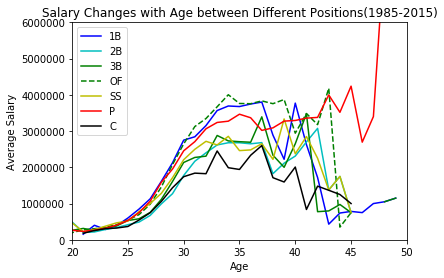

In [6]:
player = pd.read_csv("/home/jallen17/baseball_data/People.csv")
player_position = pd.merge(salary, fielding, on = ["playerID","yearID"])[["yearID", "playerID", "salary", "POS"]]
player_position = pd.merge(player_position, player, on = ["playerID"], how = "left")[["yearID", "playerID","salary", "POS", "birthYear"]]
player_position["age"] = player_position["yearID"] - player_position["birthYear"] 
player_position = player_position[player_position.yearID >= 1985]
data = player_position.groupby(["age", "POS"]).mean()["salary"].unstack()
plt.plot(data["1B"], 'b-', data["2B"], 'c-', data["3B"], 'g-', data["OF"], 'g--', data["SS"], 'y-', data['P'],'r-', data['C'],'k-')
_ = plt.ylabel("Average Salary")
_ = plt.xlabel("Age")
_ = plt.legend(["1B",'2B','3B','OF','SS',"P","C"],loc = 'upper left')
_ = plt.title("Salary Changes with Age between Different Positions(1985-2015)")
_ = plt.xlim([20,50])
_ = plt.ylim([0,6000000])

## Salaries by age over the years

Here we show a graphic that reflects how players at different positions have been paid over the years. You can see similar trends over the years to what is shown above, where players tend to be paid more in what is considered their primer production years.

In [7]:
init_notebook_mode(connected=True)

salaries=pd.read_csv("/home/jallen17/baseball_data/Salaries.csv")
fielding=pd.read_csv("/home/jallen17/baseball_data/Fielding.csv")
player = pd.read_csv("/home/jallen17/baseball_data/People.csv")
player_position = pd.merge(salaries, fielding, on = ["playerID","yearID"])[["yearID", "playerID", "salary", "POS"]]
player_position = pd.merge(player_position, player, on = ["playerID"], how = "left")[["yearID", "playerID","salary", "POS", "birthYear"]]
player_position["age"] = player_position["yearID"] - player_position["birthYear"] 
player_position = player_position[player_position.yearID >= 1985]
years_from_col = set(player_position['yearID'])
years_ints = sorted(list(years_from_col))
years = [str(year) for year in years_ints]



# make list of positions

positions = []
for position in player_position['POS']:
    if position not in positions: 
        positions.append(position)

# make figure
figure = {
    'data': [],
    'layout': {},
    'frames': []
}

# fill in most of layout
figure['layout']['xaxis'] = {'range': [20,50], 'title': 'Age'}
figure['layout']['yaxis'] = {'title': 'Salary', 'type': 'log'}
figure['layout']['hovermode'] = 'closest'
figure['layout']['sliders'] = {
    'args': [
        'transition', {
            'duration': 400,
            'easing': 'cubic-in-out'
        }
    ],
    'initialValue': '1952',
    'plotlycommand': 'animate',
    'values': years,
    'visible': True
}
figure['layout']['updatemenus'] = [
    {
        'buttons': [
            {
                'args': [None, {'frame': {'duration': 500, 'redraw': False},
                         'fromcurrent': True, 'transition': {'duration': 300, 'easing': 'quadratic-in-out'}}],
                'label': 'Play',
                'method': 'animate'
            },
            {
                'args': [[None], {'frame': {'duration': 0, 'redraw': False}, 'mode': 'immediate',
                'transition': {'duration': 0}}],
                'label': 'Pause',
                'method': 'animate'
            }
        ],
        'direction': 'left',
        'pad': {'r': 10, 't': 87},
        'showactive': False,
        'type': 'buttons',
        'x': 0.1,
        'xanchor': 'right',
        'y': 0,
        'yanchor': 'top'
    }
]

sliders_dict = {
    'active': 0,
    'yanchor': 'top',
    'xanchor': 'left',
    'currentvalue': {
        'font': {'size': 20},
        'prefix': 'Year:',
        'visible': True,
        'xanchor': 'right'
    },
    'transition': {'duration': 300, 'easing': 'cubic-in-out'},
    'pad': {'b': 10, 't': 50},
    'len': 0.9,
    'x': 0.1,
    'y': 0,
    'steps': []
}

# make data
year = 1985
for position in positions:
    dataset_by_year = player_position[player_position['yearID'] == year]
    dataset_by_year_and_cont = dataset_by_year[dataset_by_year['POS'] == position]

    data_dict = {
        'x': list(dataset_by_year_and_cont['age']),
        'y': list(dataset_by_year_and_cont['salary']),
        'mode': 'markers',
        'text': list(dataset_by_year_and_cont['POS']),
        'marker': {
            'sizemode': 'area',
            'sizeref': 200000,
            
        },
        'name': position
    }
    figure['data'].append(data_dict)
    
# make frames
for year in years:
    frame = {'data': [], 'name': str(year)}
    for position in positions:
        dataset_by_year = player_position[player_position['yearID'] == int(year)]
        dataset_by_year_and_cont = dataset_by_year[dataset_by_year['POS'] == position]

        data_dict = {
            'x': list(dataset_by_year_and_cont['age']),
            'y': list(dataset_by_year_and_cont['salary']),
            'mode': 'markers',
            'text': list(dataset_by_year_and_cont['POS']),
            'marker': {
                'sizemode': 'area',
                'sizeref': 200000,
                
            },
            'name': position
        }
        frame['data'].append(data_dict)

    figure['frames'].append(frame)
    slider_step = {'args': [
        [year],
        {'frame': {'duration': 300, 'redraw': False},
         'mode': 'immediate',
       'transition': {'duration': 300}}
     ],
     'label': year,
     'method': 'animate'}
    sliders_dict['steps'].append(slider_step)

    
figure['layout']['sliders'] = [sliders_dict]

iplot(figure)

## Payrolls for the top teams

For this part, we show a relationship between team success in the regular season and their total payroll. As the graphic shows, we find that, in general, the teams that had the most success were the teams that spent the most money. The dataset "Teams" has the variable of Rank, which roughly corresponds to how teams ended the regular season (though this is a little confused by post-season structure, as you can see by the lines that stop or disappear), so we looked the relationship between teams' rank and salary. We merged Teams.csv and Salaries.csv into one dataframe and grouped by the yearID and Rank.Then we renamed each column because the columns' name were numbers initially and could not be used in a dataframe slice. We defined a dictionary to set every rank's color. Finally, we defined a function to plot a picture about the rank vs year and salary.

One interesting aspect of these data are that you can see the changes the league has gone through reflected in this plot. In  1993, divisions were reorganized from 2 divisions to 3 with the addition of two new expansion teams, and again in 1998 with the addition of 2 more new teams, and the leagues were reorganized in 2012 due to interleague play and the addition of the wildcard playoff game.

In [8]:
# plot each rank 's average salary among each year.
teams = pd.read_csv("/home/jallen17/baseball_data/Teams.csv")
salary = pd.read_csv("/home/jallen17/baseball_data/Salaries.csv")
data1 = pd.merge(teams,salary)[["yearID", "teamID", "Rank", "salary"]]
data5 = data1.groupby(["yearID", "Rank"])["salary"].mean().unstack()
data5.columns = ['1st place', '2nd place', '3rd place', '4th place', '5th place', '6th place', '7th place']
d = {}
d = {"1st place" : 'b', "2nd place" : 'c',"3rd place" : 'g',"4th place":'m',"5th place":'y','6th place':'r','7th place' :'k'}
def f(Rank):
    if(Rank=="all"):
        plt.plot(data5["1st place"], 'b', data5["2nd place"], 'c', data5["3rd place"], 'g', data5["4th place"], 'm', data5["5th place"], 'y',
                 data5['6th place'],'r', data5['7th place'],'k')
        plt.legend(d, loc='upper left')
    else:
        plt.plot(data5[Rank], d[Rank])
        plt.legend([Rank],loc='upper left')
    plt.xlim([1985, 2017])    
    plt.title("Payroll by year for the top teams in baseball")
    plt.ylabel("Salary")
    plt.xlabel("Year")
    plt.rcParams["figure.dpi"] = 100
    
interact(f,Rank={"All":"all", "1st place": "1st place","2nd place":'2nd place',"3rd place": '3rd place',"4th place":'4th place',
                 "5th place":'5th place',"6th place":"6th place","7th place":"7th place"});



interactive(children=(Dropdown(description='Rank', options={'All': 'all', '1st place': '1st place', '2nd place': '2nd place', '3rd place': '3rd place', '4th place': '4th place', '5th place': '5th place', '6th place': '6th place', '7th place': '7th place'}, value='all'), Output()), _dom_classes=('widget-interact',))

## Heatmap of pitching attributes

Here, we present a heatmap of different attributes of pitching correlated against each other to see if any patterns emerge. As this graphic shows, performance in terms of wins and losses has a very low correlation with salary. While things like batters faced and hits against correlate much more strongly with salary, which you expect since starting pitchers make more money and they face more batters and thus will give up more hits.

Other unsuprising trends is a correlation between giving up hits and losing, and a pretty good correlation between number of wins and number of shutouts pitched. While there wasn't anything overly surprising, it gives a good way to quickly evaluate the raw data.

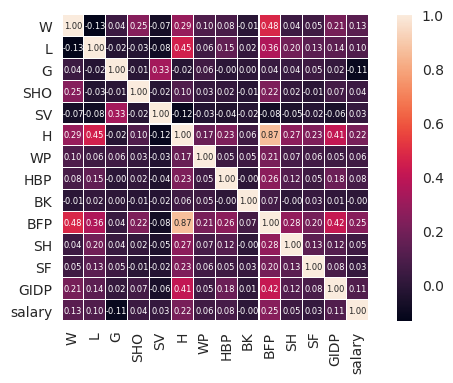

In [9]:
PitchingPost = pd.read_csv("/home/jallen17/baseball_data/PitchingPost.csv") 
salaries = pd.read_csv("/home/jallen17/baseball_data/Salaries.csv").loc[:,["playerID","salary"]]
data3 = pd.merge(PitchingPost,salaries)
sns.set(style='whitegrid', context='notebook')
cols = ['W', 'L', 'G', 'SHO',
             'SV', 'H', 'WP', 'HBP', 'BK',
             'BFP', 'SH', 'SF', 'GIDP', 'salary']
# create a heatmap to show the correlation among each performance variable and salary.
cm = np.corrcoef(data3[cols].values.T) 
sns.set(font_scale=1)

hm = sns.heatmap(cm,
       annot=True,
       square=True,
       fmt='.2f',
       annot_kws={'size': 6},
       linewidths = 0.05,
       yticklabels=cols,
       xticklabels=cols)
plt.rcParams["figure.dpi"] = 100
plt.tight_layout()

## On-base-plus-slugging comparison

In baseball, on-base-plus-slugging is a stat that reflects players' hitting performance. As it is two percentages addedd together, it is essentially meaningless, but serves as a way to compare players across the league. On-base percentage is a measure of the hits, walks, and hit-by-pitches a player received, divided by total plate appearances. Slugging percentage is basically a weighted batting average, where doubles are weighted 2, triples 3 and homeruns 4. The total bases are divided by the number of official at-bats (defined as a plate appearance that doesn't end in a walk or sacrifice). OPS is a good predictor of future performance as OBP and power tend to be consistent across players' careeres. There are further refinements, such as OPS+, which normalizes OPS by the league average. Due to some outliers for players with few plate appearances, we set a reasonable lower limit to the number of at-bats. This should have the effect of focusing the data only on regular hitters (American League pitchers, for example, only bat in interleague play, and relief pitchers hardly bat at all).

Specifically, we are examining here the performance of players who played in the post-season by comparing their post-season and regular season OPS, to look for interesting features. Do players step it up in the postseason, or crack under the pressure?

For a first pass at the post-season OPS v regular season OPS data, we made a hexbin plot with interactions that allow you to select an OPS range and date range. The OPS range is set to show all values at the lowest end, beyond that it shows ranges that coincide with Bill James categories of hitter abilities:

| Category | Classification | OPS Range       |
|----------|----------------|-----------------|
| A        | Great          | .9000 or higher |
| B        | Very Good      | .8333 to .8999  |
| C        | Above Average  | .7667 to .8333  |
| D        | Average        | .7000 to .7666  |
| E        | Below Average  | .6334 to .6999  |
| F        | Poor           | .5667 to .6333  |
| G        | Very Poor      | .5666 and lower |

For the years, the lowest setting shows all years, and beyond that it shows the decade before the shown date, so 1990 shows the data from the '90s. Histograms show the distribution of the OPS values in the regular season and post-season. Only regular season for players who appeared in the post-season is shown. While there are some interesting features of this data, the main takeaway was that the performance in both realms followed a normal distribution overall. Some good players played bad, some bad players played well, but overall they tended to perform at the same level. So Billy Beane's claim that his advanced analytics techniques don't work in the postseason was untrue. Turned out his teams were just unlucky outliers.

In [2]:
batting = pd.read_csv('/home/jallen17/baseball_data/Batting.csv')
post_batting = pd.read_csv('/home/jallen17/baseball_data/BattingPost.csv')

In [3]:
@ipywidgets.interact(level = (0.5666, 1, .0666), year = (1910, 2020, 10))
def plot(level = .5666, year = 1910):
    if year == 1910:
        post_season=post_batting
    elif level == 1920:
        post_season = post_batting.loc[post_batting['yearID'] < year]
    else:
        post_season = post_batting.loc[(post_batting['yearID'] > year-10) & (post_batting['yearID'] <= year)]
    reg_season = batting.set_index(['playerID', 'yearID'])
    post_season = post_season.set_index(['playerID', 'yearID'])
    reg_season = reg_season.groupby(['playerID', 'yearID']).sum()
    post_season = post_season.groupby(['playerID', 'yearID']).sum()
    reg_season = reg_season.loc[reg_season.AB >= 12]
    post_season = post_season.loc[post_season.AB >= 12]
    reg_season['OBP'] = (reg_season['H'] + reg_season['BB'] + reg_season['HBP']) / (reg_season['AB'] + reg_season['BB'] + reg_season['HBP'] + reg_season['SF'])
    reg_season['Slug'] = ((reg_season['H']-reg_season['2B']-reg_season['3B']-reg_season['HR']) + (2*reg_season['2B']) + (3*reg_season['3B']) + (4*reg_season['HR']))/reg_season['AB']
    reg_season['OPS'] = reg_season['OBP'] + reg_season['Slug']
    post_season['OBP'] = (post_season['H'] + post_season['BB'] + post_season['HBP']) / (post_season['AB'] + post_season['BB'] + post_season['HBP'] + post_season['SF'])
    post_season['Slug'] = ((post_season['H']-post_season['2B']-post_season['3B']-post_season['HR']) + (2*post_season['2B']) + (3*post_season['3B']) + (4*post_season['HR']))/post_season['AB']
    post_season['OPS'] = post_season['OBP'] + post_season['Slug']
    post_season.rename(columns={'OPS': 'postOPS'}, inplace=True)
    post_season_OPS = pd.DataFrame(post_season.loc[:, 'postOPS'])
    reg_season_OPS = pd.DataFrame(reg_season.loc[:, 'OPS'])
    OPS_table = post_season_OPS.join(reg_season_OPS)
    OPS_table = OPS_table.fillna(0)
    
    if level == 0.5666:
        OPS_table = OPS_table
    elif level >= 0.8334:
        OPS_table = OPS_table.loc[(OPS_table.OPS > 0.8999) & (OPS_table.OPS < 2)]
    else:
        OPS_table = OPS_table.loc[(OPS_table.OPS  > level) & (OPS_table.OPS <= level+0.666)]
    
    x = OPS_table.loc[:, 'OPS']
    y = OPS_table.loc[:, 'postOPS']
    ax1 = plt.axes([0.0, 0.0, 1.0, 1.0])
    ax2 = plt.axes([1.0, 0.0, 0.25, 1.0], sharey = ax1)
    ax3 = plt.axes([0.0, 1.0, 1.0, 0.25], sharex = ax1)

    gridsize = 64

    ax1.hexbin(x, y, bins = 'log', gridsize = gridsize)
    
    ax2.hist(y, orientation='horizontal', bins = gridsize)
    ax2.set_frame_on(False)
    ax3.hist(x, orientation='vertical', bins = gridsize)
    ax3.set_frame_on(False)
    ax1.set_xlabel("Regular season OPS", fontsize="18")
    ax1.set_ylabel("Post-season OPS", fontsize="18")
    ax2.tick_params(axis='y', which='both', right='off', left='off', labelleft='off')
    ax3.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    ax3.set_title("Reg season OPS v Post-season OPS", fontsize="24")
    # plt.rcParams["figure.dpi"] = 75;


interactive(children=(FloatSlider(value=0.5666, description='level', max=1.0, min=0.5666, step=0.0666), IntSlider(value=1910, description='year', max=2020, min=1910, step=10), Output()), _dom_classes=('widget-interact',))

## Gaussian KDE + interactivity

For this plot, we look at the same data but in a different way. The base of this plot is a scatter plot of all the data, which is then overlaid with a Gaussian kernel density estimate, shown as color. This is an approximation of the probability density at each point, and gives a visual representation of how concentrated the points are in the scatter. The interesting takeaways for me is that the density was never in the red. So the data do follow a normal distribution, but with pretty wide standard deviation (which is also fairly evident in the histograms above)

In [4]:
@ipywidgets.interact(level = (0.5666, 1, .0666), year = (1910, 2020, 10))
def plot(level = .5666, year = 1910):
    if year == 1910:
        post_season=post_batting
    elif level == 1920:
        post_season = post_batting.loc[post_batting['yearID'] < year]
    else:
        post_season = post_batting.loc[(post_batting['yearID'] > year-10) & (post_batting['yearID'] <= year)]
    reg_season = batting.set_index(['playerID', 'yearID'])
    post_season = post_season.set_index(['playerID', 'yearID'])
    reg_season = reg_season.groupby(['playerID', 'yearID']).sum()
    post_season = post_season.groupby(['playerID', 'yearID']).sum()
    reg_season = reg_season.loc[reg_season.AB >= 12]
    post_season = post_season.loc[post_season.AB >= 12]
    reg_season['OBP'] = (reg_season['H'] + reg_season['BB'] + reg_season['HBP']) / (reg_season['AB'] + reg_season['BB'] + reg_season['HBP'] + reg_season['SF'])
    reg_season['Slug'] = ((reg_season['H']-reg_season['2B']-reg_season['3B']-reg_season['HR']) + (2*reg_season['2B']) + (3*reg_season['3B']) + (4*reg_season['HR']))/reg_season['AB']
    reg_season['OPS'] = reg_season['OBP'] + reg_season['Slug']
    post_season['OBP'] = (post_season['H'] + post_season['BB'] + post_season['HBP']) / (post_season['AB'] + post_season['BB'] + post_season['HBP'] + post_season['SF'])
    post_season['Slug'] = ((post_season['H']-post_season['2B']-post_season['3B']-post_season['HR']) + (2*post_season['2B']) + (3*post_season['3B']) + (4*post_season['HR']))/post_season['AB']
    post_season['OPS'] = post_season['OBP'] + post_season['Slug']
    post_season.rename(columns={'OPS': 'postOPS'}, inplace=True)
    post_season_OPS = pd.DataFrame(post_season.loc[:, 'postOPS'])
    reg_season_OPS = pd.DataFrame(reg_season.loc[:, 'OPS'])
    OPS_table = post_season_OPS.join(reg_season_OPS)
    OPS_table = OPS_table.fillna(0)
    
    if level == 0.5666:
        OPS_table = OPS_table
    elif level >= 0.8334:
        OPS_table = OPS_table.loc[(OPS_table.OPS > 0.8999) & (OPS_table.OPS < 2)]
    else:
        OPS_table = OPS_table.loc[(OPS_table.OPS  > level) & (OPS_table.OPS <= level+0.666)]
    
    x = OPS_table.loc[:, 'OPS']
    y = OPS_table.loc[:, 'postOPS']
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=100, edgecolor='')
    plt.show()

interactive(children=(FloatSlider(value=0.5666, description='level', max=1.0, min=0.5666, step=0.0666), IntSlider(value=1910, description='year', max=2020, min=1910, step=10), Output()), _dom_classes=('widget-interact',))